# Reinforcement Learning - Laboratory

In this laboratory, you will work with the model CSTR from the PC-Gym framework. You will design,
train, evaluate and tune the algorithm hyperparameters to enhance the performance of the trained policy.

## Task 1: Train on the CSTR environment using the default setup and compare with the NMPC oracle.

The definition of the CSTR is the same as in [pc-gym Continuously Stirred Tank Reactor](https://maximilianb2.github.io/pc-gym/env/cstr/)

In [1]:
from pcgym import make_env
import numpy as np
from stable_baselines3 import PPO, SAC, DDPG
from visualization import get_data_from, performance_plots
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


The training is divided into episodes each corresponding to 60 time steps, which is 26 simulation seconds. A
variation of these values affects the frequency in which the system is updated (control frequency).

In [2]:
episode_length_steps = 60
simulation_length_seconds = 26

The definition of the training environment includes set parameters like the target (setpoint), action space,
observation space and weights of the reward components.

In [3]:
setpoint = {'Ca': [0.85 for _ in range(int(episode_length_steps / 2))] + [0.9 for _ in range(int(episode_length_steps / 2))]}

action_space = {
    'low': np.array([295.], dtype=np.float32),
    'high': np.array([302.], dtype=np.float32)
}

observation_space = {
    'low': np.array([0.7, 300., 0.8], dtype=np.float32),
    'high': np.array([1., 350., 0.9], dtype=np.float32)
}

initial_conditions = np.array([0.8, 330., 0.85])

reward_scale = {'Ca': 1e3}

environment_parameters = {
    'N': episode_length_steps,
    'tsim': simulation_length_seconds,
    'SP': setpoint,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': initial_conditions,
    'model': 'cstr',
    'r_scale': reward_scale,
    'normalize_a': True,
    'normalize_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.1
}
environment = make_env(environment_parameters)

The total length of the training. Different algorithms require a different number of interactions (samples) to reach
reward saturation, so the same training steps would require a different time budget.

In [7]:
training_time_steps = 50000

In [9]:
PPO_policy = PPO('MlpPolicy', environment, verbose=1, tensorboard_log="logs/ppo").learn(50000, tb_log_name='ppo')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo\ppo_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -70.5    |
| time/              |          |
|    fps             | 460      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 59           |
|    ep_rew_mean          | -53.6        |
| time/                   |              |
|    fps                  | 423          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0041696266 |
|    clip_fraction        | 0.0237       |
|    clip_range         

Further details on the training log can be found in the [Stable-Baselines3 Logger documentation](https://stable-baselines3.readthedocs.io/en/master/common/logger.html)

Print the neural network architecture including the activation function

In [6]:
PPO_policy.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

Save the policy to a zip file to future deployment

In [10]:
PPO_policy.save(f'policies/ppo.zip')

Evaluate a trained policy against the NMPC oracle. Add to the `policies` dictionary how many trained policies as you
want to include in the evaluation and comparison.

PPO:
  Median Absolute Deviation (MAD): 1.4408


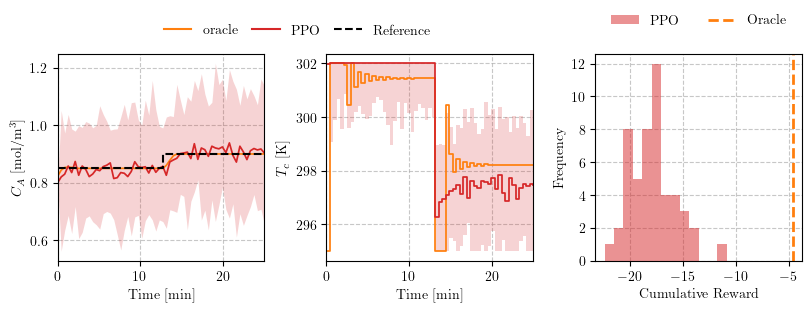

In [11]:

policies = {'PPO': PPO_policy}
get_data_from(policies, environment, 'ppo_data.npy')
data = np.load('ppo_data.npy', allow_pickle=True).item()
performance_plots(data, list(policies.keys()))

## SAC

In [ ]:
lr = 0.001
training_time_steps = 15000

SAC_policy = SAC('MlpPolicy', environment, verbose=1, tensorboard_log="logs/sac")

# SAC_policy = SAC(
#     "MlpPolicy",
#     env = environment,
#     learning_rate=3e-4,
#     gamma=0.99,
#     learning_starts=256,
#     batch_size=256,
#     buffer_size=1_000_000,
#     ent_coef="auto",
#     train_freq=1,
#     gradient_steps=1,
#     tensorboard_log="logs/sac_cstr/",
#     verbose=1
# )

SAC_policy.learn(training_time_steps, tb_log_name='sac')
SAC_policy.save(f'policies/sac.zip')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/sac\sac_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -58.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 69       |
|    time_elapsed    | 3        |
|    total_timesteps | 236      |
| train/             |          |
|    actor_loss      | 0.0606   |
|    critic_loss     | 0.606    |
|    ent_coef        | 0.961    |
|    ent_coef_loss   | -0.0662  |
|    learning_rate   | 0.0003   |
|    n_updates       | 135      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -32.8    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 39       |
|    time_elapsed    | 12       |
|    total_timesteps | 472    

## DDPG

In [9]:
training_time_steps = 15000

DDPG_policy = DDPG('MlpPolicy', environment, verbose=1, tensorboard_log="logs/ddpg")

DDPG_policy.learn(training_time_steps,tb_log_name='ddpg')
DDPG_policy.save(f'policies/ddpg.zip')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ddpg\ddpg_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -107     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 132      |
|    time_elapsed    | 1        |
|    total_timesteps | 236      |
| train/             |          |
|    actor_loss      | 2.72     |
|    critic_loss     | 0.835    |
|    learning_rate   | 0.001    |
|    n_updates       | 135      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -16.9    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 105      |
|    time_elapsed    | 4        |
|    total_timesteps | 472      |
| train/             |          |
|    actor_loss      | 2.6  

KeyboardInterrupt: 

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO:
  Median Absolute Deviation (MAD): 1.3964
SAC:
  Median Absolute Deviation (MAD): 2.3393
DDPG:
  Median Absolute Deviation (MAD): 3.8631


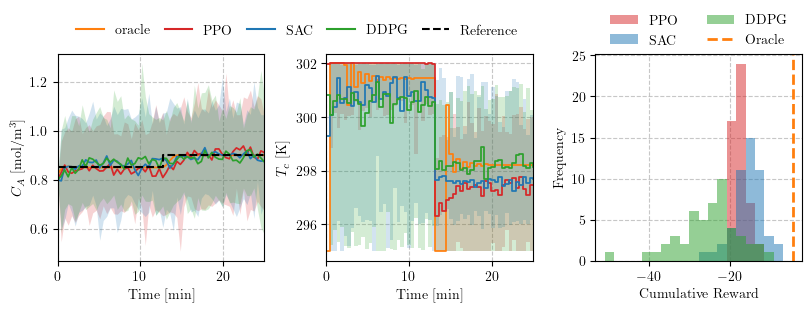

In [ ]:
PPO_policy = PPO.load("policies/ppo", env=environment)
SAC_policy = SAC.load("policies/sac", env=environment)
DDPG_policy = DDPG.load("policies/ddpg", env=environment)


policies = {'PPO': PPO_policy, 'SAC': SAC_policy, 'DDPG': DDPG_policy}
get_data_from(policies, environment, 'task1_data.npy')
data = np.load('task1_data.npy', allow_pickle=True).item()
performance_plots(data, list(policies.keys()))

Test different RL algorithms (SAC, DDPG) in the same environment by adding to the previous cells:
1. [Imports] Import SAC and DDPG from Stable-Baselines3
2. [Training] Add two new variables (`SAC_policy` and `DDPG_policy`) and train them using the same parameters as for
PPO. For SAC and DDPG set the training length at 15000 time steps.
3. [Evaluation and comparison] Add the SAC and DDPG policies to the `policies` dictionary and execute the simulation
and comparison to see the performance of the different algorithms against the NMPC oracle.

If you want to log the learning curves during training you can add the argument `tensorboard_log="target_directory"`
to the `PPO` builder, and `tb_log_name=tb_log_name` to the `learn` method.

You can monitor the training or even study the learning curves after training by running on a terminal: `tensorboard --logdir=target_directory`

*Use this cell to discuss the performances of the three algorithms.*

Guide questions:
- Is this result conclusive on which algorithm is better or worst for this problem?
- Could you guess which factors/parameters would be changed to improve the performance of the algorithms in
this problem?

SAC seems to have the highest cumulative reward. The concentration amount seems to be pretty much the same across the every model/policies, very jittery. Looking at the control chart, T_c, the PPO seems to saturate the first 15 minutes. Looking at the plots from the tensorboard, we can see that on the rollout/ep_rew_mean (reward per episode) do not seem to converge hence the low training length of 15k. This is of course a metric to look after when training. So no, it is not conclusive because we cannot have the same paramters for each model/policy and expect the models to perform fair.

## Task 1.1 - Optional: Train a new policy using a custom reward that adds penalization for high changes in the applied actions

In [2]:
from custom_reward import oracle_reward

In [6]:
custom_reward_environment_parameters = {
    'N': episode_length_steps,
    'tsim': simulation_length_seconds,
    'SP': setpoint,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': initial_conditions,
    'model': 'cstr',
    'r_scale': {'Ca': 1},
    'normalize_a': True,
    'normalize_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.1,
    'custom_reward': oracle_reward
}

custom_reward_environment = make_env(custom_reward_environment_parameters)

In [39]:
# Add the policy variables and train for at least 10000 time steps using the `custom_reward_environment`. After
# training run the performance evaluation and plotting to compare the performance of the new
# policy against the NMPC oracle.

In [21]:

training_time_steps=50000

PPO_policy = PPO('MlpPolicy',custom_reward_environment, verbose=1, tensorboard_log="logs/ppo").learn(training_time_steps, tb_log_name='ppo_custom')
PPO_policy.save(f'policies/ppo_custom.zip')

training_time_steps=15000
SAC_policy = SAC('MlpPolicy', custom_reward_environment, verbose=1, tensorboard_log="logs/sac")
SAC_policy.learn(training_time_steps, tb_log_name='sac_custom')
SAC_policy.save(f'policies/sac_custom.zip')


DDPG_policy = DDPG('MlpPolicy',custom_reward_environment, verbose=1, tensorboard_log="logs/ddpg")
DDPG_policy.learn(training_time_steps,tb_log_name='ddpg_custom')
DDPG_policy.save(f'policies/ddpg_custom.zip')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo\ppo_custom_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59       |
|    ep_rew_mean     | -13.3    |
| time/              |          |
|    fps             | 833      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 59          |
|    ep_rew_mean          | -13.6       |
| time/                   |             |
|    fps                  | 663         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003316577 |
|    clip_fraction        | 0.0159      |
|    clip_range           | 0

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO:
  Median Absolute Deviation (MAD): 0.6976
SAC:
  Median Absolute Deviation (MAD): 0.7396
DDPG:
  Median Absolute Deviation (MAD): 0.7941


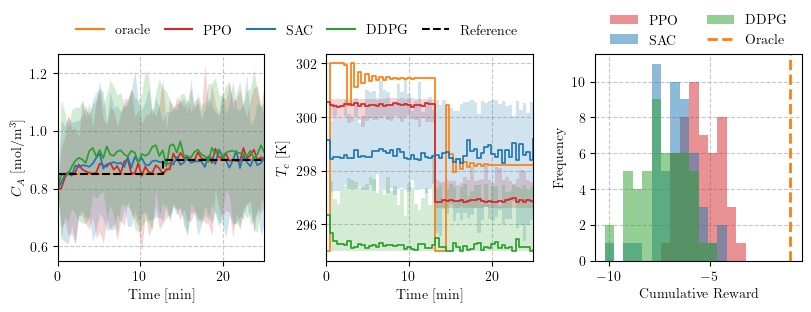

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO:
  Median Absolute Deviation (MAD): 1.3964
SAC:
  Median Absolute Deviation (MAD): 2.3393
DDPG:
  Median Absolute Deviation (MAD): 3.8631


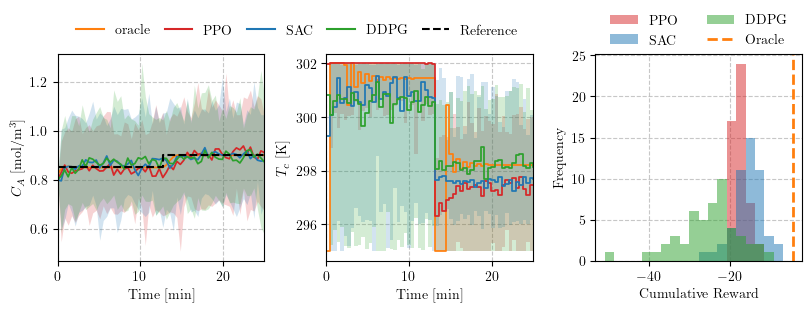

In [19]:
PPO_policy = PPO.load("policies/ppo_custom", env=custom_reward_environment)
SAC_policy = SAC.load("policies/sac_custom", env=custom_reward_environment)
DDPG_policy = DDPG.load("policies/ddpg_custom", env=custom_reward_environment)

policies = {'PPO': PPO_policy, 'SAC': SAC_policy, 'DDPG': DDPG_policy}
get_data_from(policies, custom_reward_environment, 'task1.1_data.npy')
data = np.load('task1.1_data.npy', allow_pickle=True).item()
performance_plots(data, list(policies.keys()))


PPO_policy = PPO.load("policies/ppo", env=environment)
SAC_policy = SAC.load("policies/sac", env=environment)
DDPG_policy = DDPG.load("policies/ddpg", env=environment)

policies = {'PPO': PPO_policy, 'SAC': SAC_policy, 'DDPG': DDPG_policy}
get_data_from(policies, environment, 'task1.1_data.npy')
data2 = np.load('task1_data.npy', allow_pickle=True).item()
performance_plots(data2, list(policies.keys()))

## Task 2: Closing the sim-to-real gap

In this example we will work with a new environment defined with constraints on the temperature $T$ to stay between
$319K$ and $331K$, and then we will add disturbances to the temperature sensor to simulate a realistic scenario.

In [4]:
Temperature_constraints = {'T':[319, 331]}
cons_type = {'T':['>=','<=']}

episode_length_steps = 60
simulation_length_seconds = 26

setpoint = {'Ca': [0.85 for _ in range(int(episode_length_steps / 2))] + [0.9 for _ in range(int(episode_length_steps / 2))]}

action_space = {
    'low': np.array([295.], dtype=np.float32),
    'high': np.array([302.], dtype=np.float32)
}

observation_space = {
    'low': np.array([0.7, 300., 0.8], dtype=np.float32),
    'high': np.array([1., 350., 0.9], dtype=np.float32)
}

initial_conditions = np.array([0.8, 330., 0.85])

reward_scale = {'Ca': 1e3}


s2r_environment_parameters = {
    'N': episode_length_steps,
    'tsim': simulation_length_seconds,
    'SP': setpoint,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': initial_conditions,
    'model': 'cstr',
    'r_scale': {'Ca': 1},
    'normalize_a': True,
    'normalize_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.1,
    'done_on_cons_vio': False,
    'constraints': Temperature_constraints,
    'r_penalty': True,
    'cons_type': cons_type
}

ti_disturbance = {'Ti': np.repeat([350, 345, 360], [episode_length_steps//4, episode_length_steps//2, episode_length_steps//4])}
ti_disturbance_space = {
    'low': np.array([320]),
    'high': np.array([350])
}


s2r_env = make_env({**s2r_environment_parameters, 'disturbance_bounds': ti_disturbance_space, 'disturbances': ti_disturbance})

c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [23]:
# Add the policy variables and train for at least 10000 time steps using the `s2r_env` environment logging the
# training curves to tensor board. After training, pick the algorithm with the wors performance, optimize some hyperparameters and present the
# performance plots before and after the hyperparameter optimization (HPO).

training_time_steps=50000

PPO_policy = PPO('MlpPolicy',s2r_env, verbose=1, tensorboard_log="logs/ppo")
PPO_policy.learn(training_time_steps, tb_log_name='ppo_task2')
PPO_policy.save(f'policies/ppo_task2.zip')

training_time_steps=15000
SAC_policy = SAC('MlpPolicy', s2r_env, verbose=1, tensorboard_log="logs/sac")
SAC_policy.learn(training_time_steps, tb_log_name='sac_task2')
SAC_policy.save(f'policies/sac_task2.zip')


DDPG_policy = DDPG('MlpPolicy',s2r_env, verbose=1, tensorboard_log="logs/ddpg")
DDPG_policy.learn(training_time_steps,tb_log_name='ddpg_task2')
DDPG_policy.save(f'policies/ddpg_task2.zip')

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/ppo\ppo_task2_2
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 59        |
|    ep_rew_mean     | -2.67e+04 |
| time/              |           |
|    fps             | 761       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 2048      |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 59            |
|    ep_rew_mean          | -2.41e+04     |
| time/                   |               |
|    fps                  | 640           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00032894174 |
|    clip_fraction        | 0           

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO:
  Median Absolute Deviation (MAD): 0.4164
SAC:
  Median Absolute Deviation (MAD): 0.0029
DDPG:
  Median Absolute Deviation (MAD): 0.0040


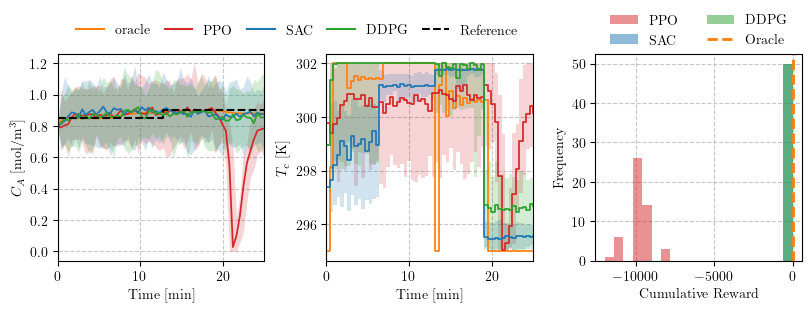

In [24]:
PPO_policy = PPO.load("policies/ppo_task2", env=s2r_env)
SAC_policy = SAC.load("policies/sac_task2", env=s2r_env)
DDPG_policy = DDPG.load("policies/ddpg_task2", env=s2r_env)

policies = {'PPO': PPO_policy, 'SAC': SAC_policy, 'DDPG': DDPG_policy}
get_data_from(policies, s2r_env, 'task2_data.npy')
data3 = np.load('task2_data.npy', allow_pickle=True).item()
performance_plots(data3, list(policies.keys()))

PPO seems to have the hardest time learning, spite the longer training time. Got a tip from a friend that PPO wont make it so i stick with SAC.

In [26]:
import torch
import optuna
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
training_time_steps = 20000

def make_sac(
    env,
    learning_rate=3e-4,
    buffer_size=300_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    ent_coef="auto",
    train_freq=1,
    gradient_steps=1,
    tensorboard_log="logs/sac",
    device=device,
    learning_starts=5_000
):
    policy_kwargs = dict(
        log_std_init=-2.0,          # 🔒 prevents NaN std
        net_arch=[256, 256],        # stable default
    )
    return SAC(
        policy="MlpPolicy",
        env=env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        batch_size=batch_size,
        tau=tau,
        gamma=gamma,
        ent_coef=ent_coef,
        train_freq=train_freq,
        gradient_steps=gradient_steps,
        learning_starts=learning_starts,
        policy_kwargs=policy_kwargs,
        verbose=0,
        tensorboard_log=tensorboard_log,
        device=device
    )

def objective(trial):

    lr = trial.suggest_float("lr", 1e-5, 3e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
    buffer_size = trial.suggest_categorical("buffer_size", [100_00, 300_000, 1_000_000])
    tau = trial.suggest_float("tau", 0.002, 0.01)
    gamma = trial.suggest_float("gamma", 0.97, 0.99)
    gradient_steps = trial.suggest_categorical("gradient_steps", [1, 2])
    learning_starts = trial.suggest_categorical("learning_starts", [0, 500, 1000, 3000])

    try:
        model = make_sac(
            env=s2r_env,
            learning_rate=lr,
            batch_size=batch_size,
            buffer_size=buffer_size,
            tau=tau,
            gamma=gamma,
            gradient_steps=gradient_steps,
            device=device,
            learning_starts=learning_starts
        )

        model.learn(total_timesteps=20_000, tb_log_name='sac_task2_optuna')

        obs, info = s2r_env.reset()
        rewards = []

        for _ in range(1_000):
            action, _ = model.predict(obs, deterministic=True)
            action = np.clip(
                action,
                s2r_env.action_space.low,
                s2r_env.action_space.high,
            )
            obs, reward, terminated, truncated, info = s2r_env.step(action)

            if not np.isfinite(obs).all() or not np.isfinite(reward):
                raise ValueError("NaN detected in environment")

            rewards.append(reward)

            if terminated or truncated:
                obs, info = s2r_env.reset()

        return float(np.mean(rewards))

    except (ValueError, RuntimeError) as e:
        print(f"Trial {trial.number} failed:", e)
        return -1e6

study = optuna.create_study(direction="maximize")
study.optimize(
    objective,
    n_trials=100,
    catch=(ValueError, RuntimeError),
)

print("Best params:", study.best_params)

[I 2026-01-03 21:28:16,349] A new study created in memory with name: no-name-98ab1c38-8aa0-4c79-8f8f-260d780674ef


Using device: cpu


c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
[I 2026-01-03 21:35:51,086] Trial 0 finished with value: -187.01287852690587 and parameters: {'lr': 5.032710320592388e-05, 'batch_size': 128, 'buffer_size': 1000000, 'tau': 0.004697326292018036, 'gamma': 0.9855338941131992, 'gradient_steps': 2, 'learning_starts': 0}. Best is trial 0 with value: -187.01287852690587.
[I 2026-01-03 21:39:18,096] Trial 1 finished with value: -183.0435782696335 and parameters: {'lr': 5.208037284781196e-05, 'batch_size': 128, 'buffer_size': 10000, 'tau': 0.006002183451045927, 'ga

Best params: {'lr': 0.0024541901848375135, 'batch_size': 128, 'buffer_size': 1000000, 'tau': 0.008860868843403959, 'gamma': 0.9770851091375135, 'gradient_steps': 1, 'learning_starts': 1000}


In [27]:
print(study.best_params)

{'lr': 0.0024541901848375135, 'batch_size': 128, 'buffer_size': 1000000, 'tau': 0.008860868843403959, 'gamma': 0.9770851091375135, 'gradient_steps': 1, 'learning_starts': 1000}


In [28]:
training_time_steps=50000

model = make_sac(
    env=s2r_env,
    learning_rate=study.best_params["lr"],
    batch_size=study.best_params["batch_size"],
    buffer_size=study.best_params["buffer_size"],
    tau=study.best_params["tau"],
    gamma=study.best_params["gamma"],
    gradient_steps=study.best_params["gradient_steps"],
    device=device,
    learning_starts=study.best_params["learning_starts"]
)


model.learn(training_time_steps, tb_log_name='sac_task2_optimized')
model.save(f'policies/sac_task2_optimized.zip')

c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [9]:
data4['reference']

{'Ca': array([0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85,
        0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85,
        0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.9 , 0.9 , 0.9 ,
        0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 ,
        0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 , 0.9 ,
        0.9 , 0.9 , 0.9 , 0.9 , 0.9 ])}

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\ludvi\Documents\Repos\R7022E-AI-in-processindustry-and-automation\.venv\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


SAC:
  Median Absolute Deviation (MAD): 0.0020
DDPG:
  Median Absolute Deviation (MAD): 0.0039


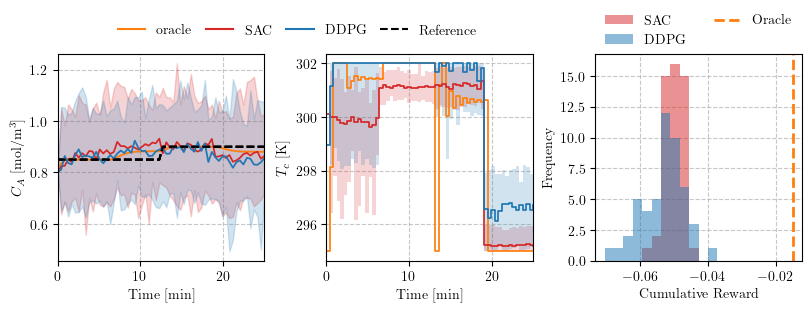

In [5]:
SAC_policy = SAC.load("policies/sac_task2_optimized", env=s2r_env)
DDPG_policy = DDPG.load("policies/ddpg_task2", env=s2r_env)

policies = {'SAC': SAC_policy, 'DDPG': DDPG_policy}

get_data_from(policies, s2r_env, 'task2_data_sac_optimized.npy')
data4 = np.load('task2_data_sac_optimized.npy', allow_pickle=True).item()
performance_plots(data4, list(policies.keys()))

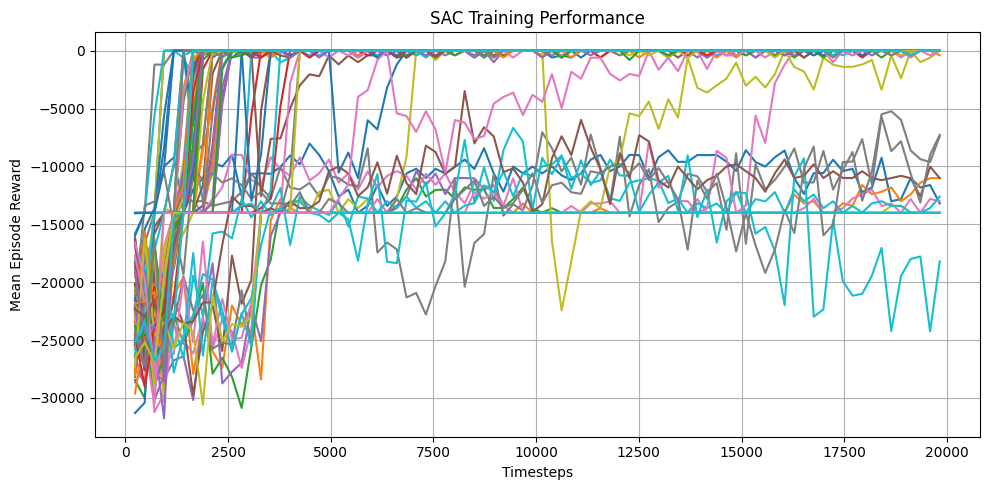

In [4]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np

def load_tb_scalars(log_dir):
    ea = EventAccumulator(log_dir)
    ea.Reload()
    scalars = {}

    for tag in ea.Tags()["scalars"]:
        events = ea.Scalars(tag)
        steps = [e.step for e in events]
        values = [e.value for e in events]
        scalars[tag] = (np.array(steps), np.array(values))

    return scalars

i = 1
plt.figure(figsize=(10, 5))
while i < 101:
    scalars = load_tb_scalars(f"logs/sac/sac_task2_optuna_{i}")
    steps, rewards = scalars["rollout/ep_rew_mean"]
    plt.plot(steps, rewards)
    i=i+1

plt.xlabel("Timesteps")
plt.ylabel("Mean Episode Reward")
plt.title("SAC Training Performance")
plt.grid(True)
plt.tight_layout()
plt.show()



*Use this cell to add your discussion about the hyperparameter tuning and performance results*

Guide questions:
- Which hyperparameter did you decide to tune and why?
- The HPO improved the final performance?
- How easy/complicated was the HPO process until reaching a better performance?

As stated in the optuna loop, the HP i chose to tune was 
- lr
- batch_size
- buffer_size
- tau
- gamma
- gradient_steps
- learning_starts

Where some were suggested by our favourite chatbot but i added learning_starts and tau. These are pretty much all the HP's that should matter the most. The performance became much better after the optimization, however, i was hoping to achieve better plots for a closer look. The HPO took about 8 hours the third run, i did however run a shorter one of about 1 hour(without learning_starts and tau), where the performance became better than unoptimized, i think the cum-sum reward was about the same as DDG then.

## Task 3: After the lab session
Using the environment defined in the task 1.1, train a policy with one of the studied algorithms, fine-tuning it if
needed and compare the policy performance against the NMPC Oracle.

In [2]:
from pcgym import make_env
import numpy as np
from stable_baselines3 import PPO, SAC, DDPG
from visualization import get_data_from, performance_plots
import torch
from custom_reward import oracle_reward

episode_length_steps = 60
simulation_length_seconds = 26

setpoint = {'Ca': [0.85 for _ in range(int(episode_length_steps / 2))] + [0.9 for _ in range(int(episode_length_steps / 2))]}

action_space = {
    'low': np.array([295.], dtype=np.float32),
    'high': np.array([302.], dtype=np.float32)
}

observation_space = {
    'low': np.array([0.7, 300., 0.8], dtype=np.float32),
    'high': np.array([1., 350., 0.9], dtype=np.float32)
}

initial_conditions = np.array([0.8, 330., 0.85])

reward_scale = {'Ca': 1e3}

custom_reward_environment_parameters = {
    'N': episode_length_steps,
    'tsim': simulation_length_seconds,
    'SP': setpoint,
    'o_space': observation_space,
    'a_space': action_space,
    'x0': initial_conditions,
    'model': 'cstr',
    'r_scale': {'Ca': 1},
    'normalize_a': True,
    'normalize_o': True,
    'noise': True,
    'integration_method': 'casadi',
    'noise_percentage': 0.1,
    'custom_reward': oracle_reward
}

environment = make_env(custom_reward_environment_parameters)

In [3]:
import torch
import optuna
import numpy as np
from stable_baselines3 import PPO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

training_time_steps = 30_000

def make_ppo(
    env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.0,
    vf_coef=0.5,
    max_grad_norm=0.5,
    tensorboard_log="logs/ppo",
    device=device,
):
    policy_kwargs = dict(
        log_std_init=-1.0,   
        net_arch=[256, 256],
    )

    return PPO(
        policy="MlpPolicy",
        env=env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        batch_size=batch_size,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        vf_coef=vf_coef,
        max_grad_norm=max_grad_norm,
        policy_kwargs=policy_kwargs,
        verbose=0,
        tensorboard_log=tensorboard_log,
        device=device,
    )

best_reward = -np.inf

def objective(trial):

    global best_reward

    lr = trial.suggest_float("lr", 1e-5, 3e-3, log=True)
    n_steps = trial.suggest_categorical("n_steps", [512, 1024, 2048])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    gamma = trial.suggest_float("gamma", 0.95, 0.99)
    gae_lambda = trial.suggest_float("gae_lambda", 0.9, 0.98)
    clip_range = trial.suggest_float("clip_range", 0.1, 0.3)
    ent_coef = trial.suggest_float("ent_coef", 0.0, 0.02)

    # PPO constraint
    if batch_size > n_steps:
        raise optuna.exceptions.TrialPruned()

    try:
        model = make_ppo(
            env=environment,
            learning_rate=lr,
            n_steps=n_steps,
            batch_size=batch_size,
            gamma=gamma,
            gae_lambda=gae_lambda,
            clip_range=clip_range,
            ent_coef=ent_coef,
            device=device,
        )

        model.learn(
            total_timesteps=training_time_steps,
            tb_log_name="ppo_task3_optuna",
        )

        obs, info = environment.reset()
        rewards = []

        for _ in range(1_000):
            action, _ = model.predict(obs, deterministic=True)
            action = np.clip(
                action,
                environment.action_space.low,
                environment.action_space.high,
            )

            obs, reward, terminated, truncated, info = environment.step(action)

            if not np.isfinite(obs).all() or not np.isfinite(reward):
                raise ValueError("NaN detected in environment")

            rewards.append(reward)

            if terminated or truncated:
                obs, info = environment.reset()

        score = float(np.mean(rewards))
        if score > best_reward:
            best_reward = score
            model.save("policies/ppo_task3_optimized.zip")
        return score

    except (ValueError, RuntimeError) as e:
        print(f"Trial {trial.number} failed:", e)
        return -1e6

study = optuna.create_study(direction="maximize")
study.optimize(
    objective,
    n_trials=50,
    catch=(ValueError, RuntimeError),
)

print("Best params:", study.best_params)


[I 2026-01-06 16:27:40,268] A new study created in memory with name: no-name-8748eb58-7ab8-4e3b-8f46-d30f0ce9493e


Using device: cpu


[I 2026-01-06 16:28:29,669] Trial 0 finished with value: -0.10316731135006106 and parameters: {'lr': 4.833004094242331e-05, 'n_steps': 1024, 'batch_size': 128, 'gamma': 0.956770925836071, 'gae_lambda': 0.9618225041677497, 'clip_range': 0.19829690199377845, 'ent_coef': 0.01177572708147607}. Best is trial 0 with value: -0.10316731135006106.
[I 2026-01-06 16:29:13,858] Trial 1 finished with value: -0.09697987574183325 and parameters: {'lr': 0.0020394611658636147, 'n_steps': 2048, 'batch_size': 256, 'gamma': 0.9683947311014173, 'gae_lambda': 0.912741286290607, 'clip_range': 0.14865996161706047, 'ent_coef': 0.007555787504226308}. Best is trial 1 with value: -0.09697987574183325.
[I 2026-01-06 16:30:03,330] Trial 2 finished with value: -0.10174652201680429 and parameters: {'lr': 3.4194694836732434e-05, 'n_steps': 2048, 'batch_size': 128, 'gamma': 0.9824957982909442, 'gae_lambda': 0.9169375479292144, 'clip_range': 0.26250302325988994, 'ent_coef': 0.010754229700974918}. Best is trial 1 with va

Best params: {'lr': 0.00016611300602813344, 'n_steps': 1024, 'batch_size': 128, 'gamma': 0.959042224943262, 'gae_lambda': 0.9215850817209673, 'clip_range': 0.19584062566480048, 'ent_coef': 0.008329739851835861}


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO Optimized:
  Median Absolute Deviation (MAD): 0.8079
PPO:
  Median Absolute Deviation (MAD): 0.6660


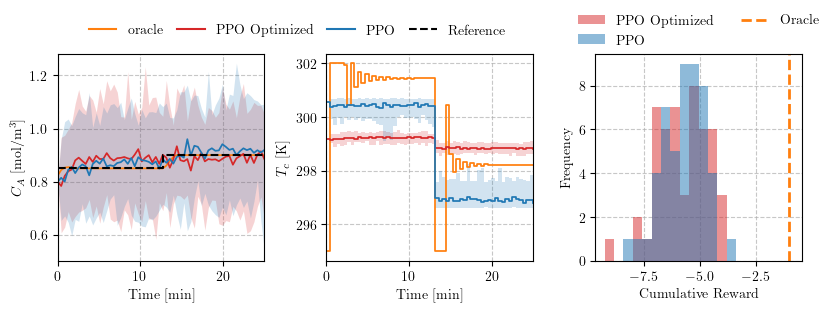

In [4]:
PPO_policy = PPO.load("policies/ppo_task3_optimized", env=environment)
PPO2_policy = PPO.load("policies/ppo_custom", env=environment)
policies = {'PPO Optimized': PPO_policy,'PPO': PPO2_policy}
get_data_from(policies, environment, 'ppo_data.npy')
data = np.load('ppo_data.npy', allow_pickle=True).item()
performance_plots(data, list(policies.keys()))

In [ ]:
import torch
import optuna
import numpy as np
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
training_time_steps = 15000

s2r_env = environment
best_reward = -np.inf
def make_sac(
    env,
    learning_rate=3e-4,
    buffer_size=300_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    ent_coef="auto",
    train_freq=1,
    gradient_steps=1,
    tensorboard_log="logs/sac",
    device=device,
    learning_starts=5_000
):
    policy_kwargs = dict(
        log_std_init=-2.0,
        net_arch=[256, 256], 
    )
    return SAC(
        policy="MlpPolicy",
        env=env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        batch_size=batch_size,
        tau=tau,
        gamma=gamma,
        ent_coef=ent_coef,
        train_freq=train_freq,
        gradient_steps=gradient_steps,
        learning_starts=learning_starts,
        policy_kwargs=policy_kwargs,
        verbose=0,
        tensorboard_log=tensorboard_log,
        device=device
    )

def objective(trial):
    global best_reward
    lr = trial.suggest_float("lr", 1e-5, 3e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])
    buffer_size = trial.suggest_categorical("buffer_size", [100_00, 300_000, 1_000_000])
    tau = trial.suggest_float("tau", 0.002, 0.01)
    gamma = trial.suggest_float("gamma", 0.97, 0.99)
    gradient_steps = trial.suggest_categorical("gradient_steps", [1, 2])
    learning_starts = trial.suggest_categorical("learning_starts", [0, 500, 1000, 3000])

    try:
        model = make_sac(
            env=s2r_env,
            learning_rate=lr,
            batch_size=batch_size,
            buffer_size=buffer_size,
            tau=tau,
            gamma=gamma,
            gradient_steps=gradient_steps,
            device=device,
            learning_starts=learning_starts
        )

        model.learn(total_timesteps=20_000, tb_log_name='sac_task3_optuna')

        obs, info = s2r_env.reset()
        rewards = []

        for _ in range(1_000):
            action, _ = model.predict(obs, deterministic=True)
            action = np.clip(
                action,
                s2r_env.action_space.low,
                s2r_env.action_space.high,
            )
            obs, reward, terminated, truncated, info = s2r_env.step(action)

            if not np.isfinite(obs).all() or not np.isfinite(reward):
                raise ValueError("NaN detected in environment")

            rewards.append(reward)

            if terminated or truncated:
                obs, info = s2r_env.reset()
        score = float(np.mean(rewards))
        if score > best_reward:
            best_reward = score
            model.save("policies/sac_task3_optimized.zip")
        return score

    except (ValueError, RuntimeError) as e:
        print(f"Trial {trial.number} failed:", e)
        return -1e6

study = optuna.create_study(direction="maximize")
study.optimize(
    objective,
    n_trials=50,
    catch=(ValueError, RuntimeError),
)

print("Best params:", study.best_params)

[I 2026-01-06 17:14:27,844] A new study created in memory with name: no-name-281a1d06-8a67-4607-a0ca-315c753fcc6b


Using device: cpu


[I 2026-01-06 17:23:03,531] Trial 0 finished with value: -0.10581859310457929 and parameters: {'lr': 4.421356635618431e-05, 'batch_size': 256, 'buffer_size': 1000000, 'tau': 0.0037388817599460986, 'gamma': 0.9786103088618792, 'gradient_steps': 2, 'learning_starts': 500}. Best is trial 0 with value: -0.10581859310457929.
[I 2026-01-06 17:29:08,803] Trial 1 finished with value: -0.09817479945140437 and parameters: {'lr': 5.3777210989726054e-05, 'batch_size': 128, 'buffer_size': 10000, 'tau': 0.006775421332556113, 'gamma': 0.9887886925308007, 'gradient_steps': 2, 'learning_starts': 3000}. Best is trial 1 with value: -0.09817479945140437.
[I 2026-01-06 17:32:24,920] Trial 2 finished with value: -0.10611178609773773 and parameters: {'lr': 3.132230831375544e-05, 'batch_size': 128, 'buffer_size': 10000, 'tau': 0.007460107636131343, 'gamma': 0.975918932308536, 'gradient_steps': 1, 'learning_starts': 3000}. Best is trial 1 with value: -0.09817479945140437.
[I 2026-01-06 17:36:43,505] Trial 3 fi

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
SAC Optimized:
  Median Absolute Deviation (MAD): 0.7298
SAC:
  Median Absolute Deviation (MAD): 0.6782


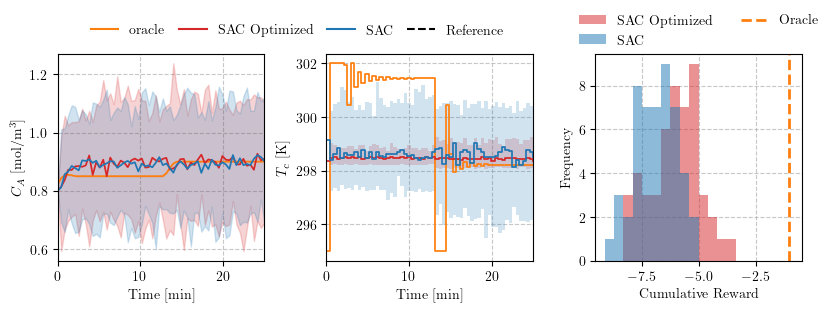

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
PPO Optimized:
  Median Absolute Deviation (MAD): 0.5546
PPO:
  Median Absolute Deviation (MAD): 0.6289


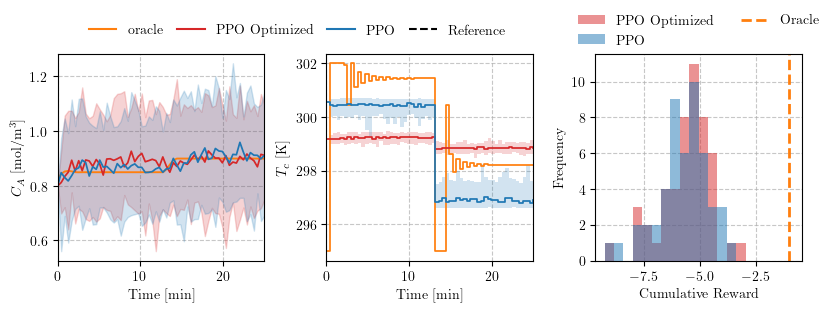

In [4]:
from visualization import get_data_from, performance_plots

SAC_policy = SAC.load("policies/sac_task3_optimized", env=environment)
SAC2_policy = SAC.load("policies/sac_custom", env=environment)
policies = {'SAC Optimized': SAC_policy,'SAC': SAC2_policy}
get_data_from(policies, environment, 'task3_sac.npy')
data = np.load('task3_sac.npy', allow_pickle=True).item()
performance_plots(data, list(policies.keys()))

PPO_policy = PPO.load('policies/ppo_task3_optimized',env=environment)
PPO2_policy = PPO.load("policies/ppo_custom", env=environment)
policies = {'PPO Optimized': PPO_policy,'PPO': PPO2_policy}
get_data_from(policies, environment, 'task3_ppo.npy')
data2 = np.load('task3_ppo.npy', allow_pickle=True).item()
performance_plots(data2, list(policies.keys()))

*Use this cell to add your discussion on the selected algorithm*

Guide questions:
- How the reward function definition impact the performances of the trained policy?
- Why did you select that algorithm over the others?
- How easy/complicated was the HPO process?
- Is the final performances as you expected?

Realized that this task was optional. The custom reward function may have a slight positive impact on sac, but it may just be the HPO. HPO was a bit tideus to set up but i think it worked well. I should have tried larger spans of suggestions and more data insight on what parameters was the most effective. 

The final performance was worst than expected, i thought the performance would be better with HPO, with a little more hope using a different reward function.
